In [79]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

In [80]:
#Suppress the "area" warnings
import warnings
warnings.filterwarnings("ignore")

In [81]:
pd.options.mode.chained_assignment = None  # default='warn'

In [82]:
DRIVE_PATH = "/Users/jerrylin/Google Drive/My Drive/CS+/Data/"
def full_path(filename):
    return DRIVE_PATH + filename

### Preprocessing, Initializing Variables, etc.

In [83]:
dist_VTD_path = full_path("code_data_NC_NCAbs_Judges.txt")
dist_shp_path = full_path('judges_NC_shapefiles')

In [84]:
#Combine today's datasets
df2 = gpd.read_file(full_path('NCabs_VTD'))
pairings = pd.read_csv(dist_VTD_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})

### Grab Comparator District

In [85]:
def get_comparators(orig_filepath, rank_num):
    #Initialize original district stats
    orig = pd.read_csv(orig_filepath, sep='\t', header=None)
    orig["sample_num"] = -1

    #Grab election data from main df2 DataFrame
    election_data = df2.loc[:, ['VTD_num', "EL16G_PR_D", 'EL16G_PR_R', 'EL16G_PR_T']]

    #Grab a list of compliant numbers
    compliant = pd.read_csv(full_path("ensembles_main_rank_" + str(rank_num) + "_compliantVerbose.txt"), sep='\t', header=None)
    compliant.rename(columns={0:"sample_num", 1:"is_compliant"}, inplace=True)
    compliant_nums = compliant[compliant.is_compliant==1].sample_num.tolist()

    #Takes about 5 seconds
    #Iterate through all the compliant samples and read in their data
    pd_lists = []
    for sample_num in compliant_nums:
        filepath = full_path("ensembles_main_rank_" + str(rank_num) 
                             + "_districtingMaps/districtingMap") + str(sample_num) + ".txt"
        new = pd.read_csv(filepath, sep='\t', header=None)
        new["sample_num"] = sample_num
        pd_lists.append(new)
    pd_lists.append(orig)

    #Concat and rename
    final = pd.concat(pd_lists)
    final.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)

    #Join with election data
    final = final.merge(election_data, how='left', on="VTD_num")

    #Group at district level
    grouped = final.groupby(["sample_num", "district"]).sum()

    #Grouped at the district level, calculate district-level stats like dem prop and rep prop
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]
    grouped['dem_win'] = 0
    grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
    grouped.drop(columns=['EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'VTD_num'], inplace=True)

    flattened = grouped.reset_index()

    #Add district-level stats to each VTD
    final2 = final.merge(flattened, how="left", left_on=['sample_num', 'district'], right_on=['sample_num', 'district'])

    orig_dst_lvl = final2.loc[final2.sample_num==-1]
    comp_dst_lvl = final2.loc[final2.sample_num!=-1]

    #Add original districting data to each comparator VTD entry — for easy calculation of differences between comparator
    final3 = comp_dst_lvl.merge(orig_dst_lvl, how="left", left_on='VTD_num', right_on='VTD_num', suffixes=('', '_orig'))
    
    #Actually, we do want orig to be labeled with column names! Since we use it later
    orig.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)
    
    return final3, orig

In [86]:
#Why do we even need orig?
final3, orig = get_comparators(orig_filepath = dist_VTD_path, rank_num=0)

### Staple Functions

In [87]:
def dist_level_data(VTD_data):
    districts = VTD_data.groupby('district')[['EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'TOTPOP']].sum().reset_index()
    districts['dem_prop'] = districts.EL16G_PR_D/districts.EL16G_PR_T
    districts['rep_prop'] = districts.EL16G_PR_R/districts.EL16G_PR_T
    return districts

In [88]:
# Calculate the Polsby Popper compactness score
def polsby_popper(shape):
    return (4 * np.pi * shape.area) / (shape.length ** 2)

In [89]:
def calc_gmandered_score(df):
    dem_filter = ((df.dem_prop > df.rep_prop) & (df.dem_prop_orig < df.rep_prop_orig)) | (((df.dem_prop_orig - df.dem_prop) > PK_PCT) & (df.dem_prop > df.rep_prop))
    rep_filter = ((df.rep_prop > df.dem_prop) & (df.rep_prop_orig < df.dem_prop_orig)) | (((df.rep_prop_orig - df.rep_prop) > PK_PCT) & (df.rep_prop > df.dem_prop))


    df['dem_gmandered'] = np.where(dem_filter, df['EL16G_PR_D'], 0)
    df['rep_gmandered'] = np.where(rep_filter, df['EL16G_PR_R'], 0)
    df['tot_gmandered'] = df.dem_gmandered + df.rep_gmandered
    
    #Summing up in total and dividing by sample num is the same as grouping by and taking mean.
    return df.tot_gmandered.sum()/NUM_SAMPLE_NUM

In [90]:
def calc_candidates(curr_data):
    curr_data[("neighborof")] = 0
    for district in range(1, 14):
        dist_comp = curr_data.loc[curr_data.district==district, "loc_prec"].tolist()
        neighbors = set()
        neighbor_list = curr_data.loc[curr_data.district==district, "neighbors"].tolist()
        for one_neighbor_list in neighbor_list:
            for item2 in one_neighbor_list:
                neighbors.add(item2)
        neighbors = neighbors.difference(dist_comp)
        curr_data.loc[curr_data.loc_prec.isin(neighbors), "neighborof"] = district
    candidates = curr_data[curr_data.neighborof!=0]
    return candidates

In [91]:
def check_compact(orig_shapes, row, COMP_DEV, remove_shape, add_shape):
    dist_comp = polsby_popper(orig_shapes.loc[row.district, 'geometry'])
    neigh_comp = polsby_popper(orig_shapes.loc[int(row.neighborof),'geometry'])
    remove_comp = polsby_popper(remove_shape)
    add_comp = polsby_popper(add_shape)
    remove_dev = (dist_comp - remove_comp) / dist_comp #pos when new worse than orig
    add_dev = (neigh_comp - add_comp) / neigh_comp #pos when new worse than orig

    #print("Compactness deviations of:", remove_dev, add_dev)
    if ((remove_dev >= COMP_DEV) or (add_dev >= COMP_DEV)):
        #print("Compactness check failed!", remove_dev, add_dev)
        return False
    else:
        #print("Compactness check passed")
        return True

In [92]:
def check_fancy_compact(orig_pols_list, temp_pols_list, row, COMP_DEV, remove_shape, add_shape):
    remove_comp = polsby_popper(remove_shape)
    add_comp = polsby_popper(add_shape)
    temp_pols_list[row.neighborof-1] = add_comp #lists index from 0
    temp_pols_list[row.district-1] = remove_comp
    
    avg_dev = (mean(orig_pols_list) - mean(temp_pols_list))/mean(orig_pols_list) #pos when temp worse than orig
    worst_dev = (min(orig_pols_list) - min(temp_pols_list))/min(orig_pols_list) #pos when temp worse than orig
    
    if ((avg_dev >= COMP_DEV) or (worst_dev >= COMP_DEV)): #if positively deviates more than comp_dev
        return False
    else:
        return True

### Run Algo

Data Needed: data, shapes, districts (dist-lvl data), scoredf

In [93]:
### STATE-SPECIFIC or unchanging CONSTANTS
NUM_DIST = 13 # Number of districts
IDEAL_POP = 733499 # Ideal population per district
PK_PCT = 0.05 # Amount of change necessary to cross packedness threshold in calc_gmandered_score_fast()
NUM_SAMPLE_NUM = final3.sample_num.nunique()

In [94]:
### Implementation variables
POP_DEV = 0.02 # Amount of acceptable population deviation
COMP_DEV = 0.1 # Amount of acceptable compactness deviation

In [95]:
### Simulated annealing specific parameters
INITPROB = 0.4 # Used to calculate initial temperature
calibrate_temp = False
STARTTEMP = 800 # If -1, we need to calculate STARTTEMP. Otherwise, use given STARTTEMP
TEMPFACTOR = 0.9747 # Cooling ratio r
MINPERCENT = 0.02 # Used to test if annealing run is frozen & should be terminated
L = 272

In [96]:
#Initialize orig_data and orig_shapes
orig_data = df2.merge(pairings, on='VTD_num')
orig_data["neighbors"] = orig_data.my_neighbo.str.split(", ")
orig_data = orig_data[['VTD_num', 'EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'TOTPOP', 'neighbors', 'district', 'loc_prec', 'geometry']]
orig_shapes = gpd.read_file(dist_shp_path)
if 'District' in orig_shapes.columns:
    orig_shapes.rename(columns={'District':'district'}, inplace=True)
orig_shapes.index = orig_shapes.district #The index is the exact district numbers
orig_pols_list = polsby_popper(orig_shapes).tolist()

In [97]:
#RERUN THIS TO FULLY RESTART ALGORITHM
# Initialize simulated annealing variables used in the algorithm
np.random.seed(0)
frozen_count = 0
temps_completed = 0
frozen = False
champ_scoredf = None
champ_data = None
iterations = 0
accepted = 0
T = STARTTEMP

orig_districts = dist_level_data(orig_data)

curr_shapes = orig_shapes.copy()
curr_scoredf = final3.copy()
#Cull the scoredf to only contain the columns we need! The copy operations will be costly otherwise
curr_scoredf = curr_scoredf[['dem_prop', 'rep_prop', 'dem_prop_orig', 'rep_prop_orig', 
                             'VTD_num', 'EL16G_PR_D', 'EL16G_PR_R', 'district_orig']]
champ_scoredf = curr_scoredf
curr_districts = orig_districts.copy()
curr_data = orig_data.copy()

count = 0
x = []
y = []

In [99]:
#Can pause this code block and continue later with your progress saved!
while not frozen:
    curr_iter_district = -1 
    curr_iter_neighborof = -1 
    curr_iter_gmandered = -1 
    update_slice = True
    count += 1
    if count % 25 == 0:
        score = calc_gmandered_score(curr_scoredf)
        x.append(count)
        y.append(score)

    print("============ Recalculating candidates", count, "============")
    candidates = calc_candidates(curr_data)

    for index, row in candidates.sample(frac=1).iterrows(): 
        #Simulated annealing checks
        if (iterations == L) & (calibrate_temp == False): #Note that iterations are only those candidate swaps which satisfy pop, contig, compact
            temps_completed += 1
            print('======= Simulated annealing run', temps_completed, '-=======')
            T = TEMPFACTOR * T
            if (accepted/iterations) < MINPERCENT:
                frozen_count += 1
                
            # Determine whether to reset frozen_count. Implemented slightly diff. from Johnson et. al
            curr_gmandered = calc_gmandered_score(curr_scoredf)
            champ_gmandered = calc_gmandered_score(champ_scoredf)
            if curr_gmandered < champ_gmandered:
                frozen_count = 0
                champ_scoredf = curr_scoredf
                champ_data = curr_data
                
            if frozen_count == 5:
                frozen = True
                break
            iterations = 0
            accepted = 0
        
        #Population check
        if ((curr_districts.loc[curr_districts.district == row.district, 'TOTPOP'].iloc[0] - row.TOTPOP) > (IDEAL_POP*(1-POP_DEV))) & (
            (curr_districts.loc[curr_districts.district == row.neighborof, 'TOTPOP'].iloc[0] + row.TOTPOP) < (IDEAL_POP*(1+POP_DEV))):
            pass
        else:
            continue
        
        #Determine whether to update the curr_df_slice (timesaving device)
        if (row.district != curr_iter_district) | (row.neighborof != curr_iter_neighborof) | (
            curr_iter_gmandered == -1):
            update_slice = True
            curr_iter_district = row.district
            curr_iter_neighborof = row.neighborof
            

        ### Check contiguity
        prec_shape = df2.loc[df2.loc_prec==row.loc_prec, 'geometry'].values[0]
        remove_shape = curr_shapes.loc[row.district, 'geometry'].difference(prec_shape)
        add_shape = curr_shapes.loc[int(row.neighborof), 'geometry'].union(prec_shape)

        if ((remove_shape.geom_type != 'Polygon') or (len(remove_shape.interiors) > 0)) or ((add_shape.geom_type != 'Polygon') or (len(add_shape.interiors) > 0)):
            #print("Contiguity check failed! Select new VTD to test.")
            continue
        else:
            #print("Contiguity check passed!")
            pass

        ### Check compactness
        '''if check_compact(orig_shapes, row, COMP_DEV, remove_shape, add_shape)==False:
            continue
        else:
            pass'''
        temp_pols_list = polsby_popper(curr_shapes).tolist()
        if check_fancy_compact(orig_pols_list, temp_pols_list, row, COMP_DEV, remove_shape, add_shape)==False:
            continue
        else:
            pass
        

        #=======Calc the current level of gerrymandering======
        #At this point, these are acceptable swaps, which count towards iteration & frozen.
        iterations += 1
        
        if update_slice:
            curr_scoredf_slice = curr_scoredf.loc[(curr_scoredf.district_orig==row.district)|(curr_scoredf.district_orig==row.neighborof)]
            curr_iter_gmandered = calc_gmandered_score(curr_scoredf_slice)
            update_slice = False

        #Perform the swap in data
        temp_data = curr_data.copy()
        temp_data.loc[temp_data.VTD_num == row.VTD_num, 'district'] = row.neighborof
        temp_districts = dist_level_data(temp_data)

        #Two cases
        #1. If dist/neighborof changes, then curr has just been updated. 
        #2. If dist/neighborof hasn't changed, curr_scoredf_slice will still be good from last iteration
        temp_scoredf_slice = curr_scoredf_slice.copy()

        #Perform the swap in the scoredf
        temp_scoredf_slice.loc[temp_scoredf_slice.VTD_num == row.VTD_num, 'district_orig'] = row.neighborof
        temp_scoredf_slice.loc[(temp_scoredf_slice.district_orig==row.neighborof),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.neighborof), ['dem_prop', 'rep_prop']].iloc[0].tolist()
        temp_scoredf_slice.loc[(temp_scoredf_slice.district_orig==row.district),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.district), ['dem_prop', 'rep_prop']].iloc[0].tolist()

        temp_gmandered = calc_gmandered_score(temp_scoredf_slice)

        if temp_gmandered < curr_iter_gmandered:
            print('good swap')
            swap = True
        elif temp_gmandered == curr_iter_gmandered:
            #Don't let zero cost swaps occur, they just repeat over and over
            swap = False
        else:
            delta = temp_gmandered-curr_iter_gmandered
            prob = math.exp((-1) * (delta) / T)
            print("Bad swap, probability of making the swap:", prob)
            swap = np.random.choice([1, 0], 1, p=[prob, 1-prob])
            if swap[0] == 1:
                print("Make swap anyways!")
                swap=True
            else:
                print('Don\'t make swap.')
                swap=False
        
        if swap == True:
            accepted += 1
            if calibrate_temp == True:
                continue
            print("swap", row.loc_prec, "VTD from", row.district, "to", row.neighborof, "base", curr_iter_gmandered, 'new', temp_gmandered)
            curr_shapes.loc[row.district, 'geometry'] = remove_shape
            curr_shapes.loc[row.neighborof, 'geometry'] = add_shape
            curr_districts = temp_districts
            curr_data = temp_data
            curr_scoredf.loc[curr_scoredf.VTD_num == row.VTD_num, 'district_orig'] = row.neighborof
            curr_scoredf.loc[(curr_scoredf.district_orig==row.neighborof),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.neighborof), ['dem_prop', 'rep_prop']].iloc[0].tolist()
            curr_scoredf.loc[(curr_scoredf.district_orig==row.district),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.district), ['dem_prop', 'rep_prop']].iloc[0].tolist()
            break #Break to recalculate candidates
    print()
    if calibrate_temp==True:
        print('calibration finished')
        break
else:
    print('program has ended! prolly froze, or done with calibration')
    print(accepted/iterations)

============ Recalculating candidates 19 ============


KeyboardInterrupt: 

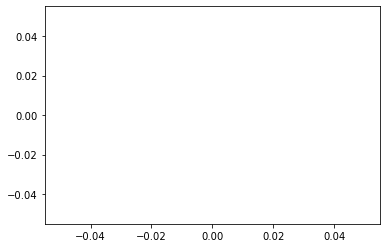

In [59]:
plt.scatter(x, y)



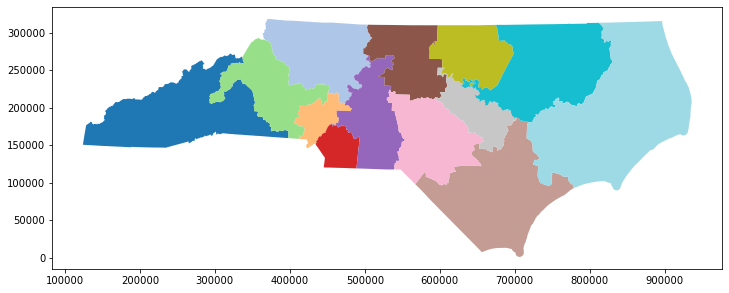

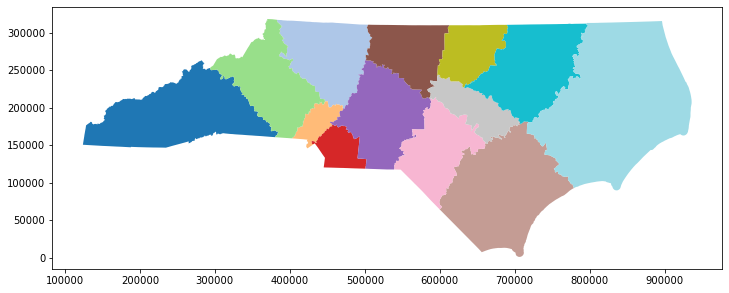

In [60]:
curr_shapes.plot(figsize=(12, 10), column='district', cmap='tab20')
orig_shapes.plot(figsize=(12, 10), column='district', cmap='tab20')

In [57]:
calc_gmandered_score(curr_scoredf)

620883.0085308057

In [61]:
print('min', min(polsby_popper(curr_shapes).tolist()))
print('mean', mean(polsby_popper(curr_shapes).tolist()))

min 0.19030434888518497
mean 0.2942352613202257


In [58]:
T

37.78729765509504

In [254]:
frozen_count

0

In [24]:
#orig_scoredf = final3.copy() Commented out whne doing timeit func.
calc_gmandered_score(final3)

931975.2995260664

### Plot dist partisanness

In [45]:
def plot_dist_partisaness(curr_districts, curr_dist_shapes):
    #Expensive operation
    curr_dist_shapes["rep_prop"] = curr_districts['rep_prop'].round(3).values
    curr_dist_shapes['coords'] = curr_dist_shapes['geometry'].apply(lambda x: x.representative_point().coords[:])
    curr_dist_shapes['coords'] = [coords[0] for coords in curr_dist_shapes['coords']]
    curr_dist_shapes.plot(figsize=(18, 16),
               column="rep_prop", cmap="coolwarm", legend=True, vmin=0, vmax=1, edgecolor="black", legend_kwds={'shrink': 0.3, 'label': 'Republican Vote %'})
    plt.title("Republican Vote Percentage Per District")
    for idx, row in curr_dist_shapes.iterrows():
        plt.annotate(s=row['district'], xy=row['coords'],
                     horizontalalignment='center')
    plt.axis('off')
    #print(calc_eff_gap(finaldf))
    plt.savefig('2016_rep_pkcrk.png', dpi=300, bbox_inches='tight')

In [48]:
def generate_dist_borders(orig_filepath):
    orig = pd.read_csv(orig_filepath, sep='\t', header=None).rename(columns={0:'VTD_num',1:'district'})
    merged = gpd.GeoDataFrame(orig.merge(df2, on='VTD_num'))
    districts = merged[['geometry', 'district']].dissolve(by='district')
    return districts

In [ ]:
curr_shapes = generate_dist_borders(full_path('570000.txt'))


In [65]:
curr_pairings = pd.read_csv(full_path('570000.txt'), sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
curr_districts = dist_level_data(df2.merge(curr_pairings, on='VTD_num'))

In [61]:
curr_shapes['district'] = curr_shapes.index #The index is the exact district numbers


/Users/jerrylin/opt/anaconda3/envs/districting/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


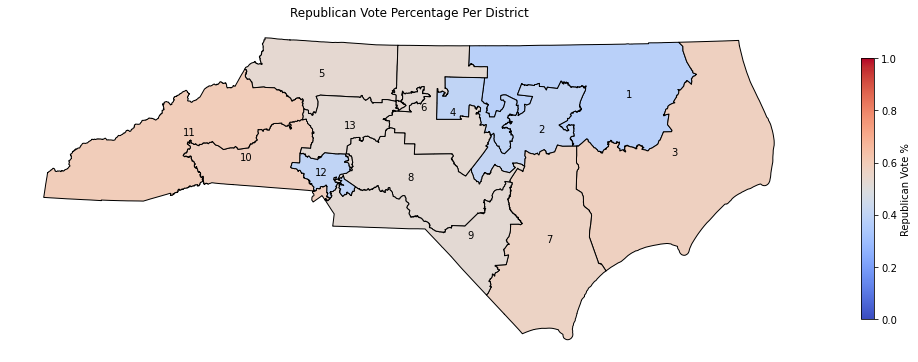

In [66]:
plot_dist_partisaness(curr_districts, curr_shapes)

/Users/jerrylin/opt/anaconda3/envs/districting/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


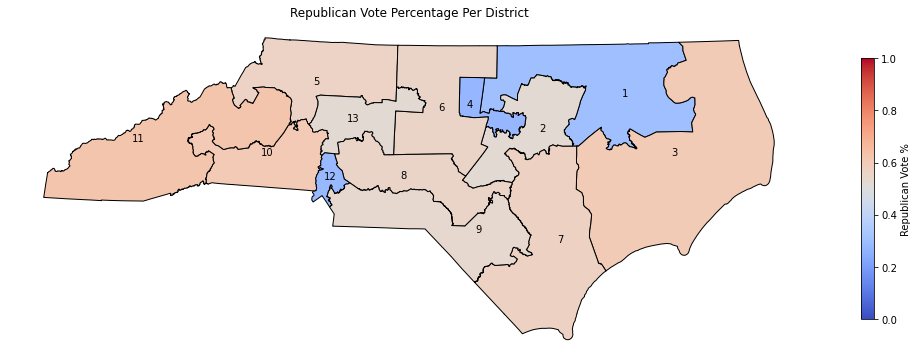

In [67]:
plot_dist_partisaness(orig_districts, orig_shapes)

### Save Output to check in Justified Chain

In [59]:
curr_data[['VTD_num', 'district']].to_csv("620000onACR.txt", sep='\t', header=False, index=False)

In [66]:
d = {'x':x, 'y': y}
x_y_dataframe = pd.DataFrame(d)
x_y_dataframe.to_csv('620000onACRscatter.txt', sep='\t', header=False, index=False)